In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_pacf

df=pd.read_excel("data/SORA_2025.xlsx")
print(df.shape)
df.tail(6)

(42, 2)


,Date,3MSORA
36,2025-07-02,0.02053
37,2025-08-01,0.01845
38,2025-09-01,0.01563
39,2025-10-01,0.01453
40,2025-11-01,0.01320
41,2025-12-01,0.01253


In [3]:
#I only took 1 column >> this impact how the graph looks later
df1 = df['3MSORA']
# Split into train and test
train = df1.iloc[:36]   # first 2 points (80% Train set); you will noticed that accuracy is impacted because the actuals changed drastically in later months
test = df1.iloc[36:]    # last 6 points (39-34)

print(train.shape)
print(test.shape)

(36,)
(6,)


In [4]:
# Tweaked from previous model BIC (2,0) 
model = ARIMA(train, order=(2,1,0)) 
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 3MSORA   No. Observations:                   36
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 189.871
Date:                Fri, 05 Dec 2025   AIC                           -373.742
Time:                        14:57:06   BIC                           -369.076
Sample:                             0   HQIC                          -372.131
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4250      0.132      3.208      0.001       0.165       0.685
ar.L2          0.3821      0.142      2.696      0.007       0.104       0.660
sigma2      1.095e-06   1.96e-07      5.586      0.0

C:\Users\jinsh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [5]:
# This means I am predicting subsequent N steps from where i start Train set
# I want to know the variance between 
forecast = model.forecast(steps=6) #Check box 12, the firsts row will affect the steps here. Step = total - first
print("Forecasted:", forecast.values.round(4))
print("Actual:", test.iloc[:6].values.round(4)) # this means I am test subsequent 3 steps from where i start Train set

Forecasted: [0.0216 0.0208 0.02   0.0194 0.0188 0.0183]
Actual: [0.0205 0.0184 0.0156 0.0145 0.0132 0.0125]


In [6]:
#Based on forecast of latest 3 months - check for accuracy
#If i extend to 5 steps, the MAPE will increase to 4%. 
rmse = np.sqrt(mean_squared_error(test, forecast))
mse = mean_squared_error(test,forecast)
mae = mean_absolute_error(test,forecast)
mape = mean_absolute_percentage_error(test,forecast)

print("RMSE:",round(rmse,3)) # RMSE and etc is not an array or Series e.g. forecast.values, but a single number > you can round directly
print("MSE:",round(mse,4))
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")

RMSE: 0.004
MSE: 0.0
MAE: 0.0040
MAPE: 0.2788


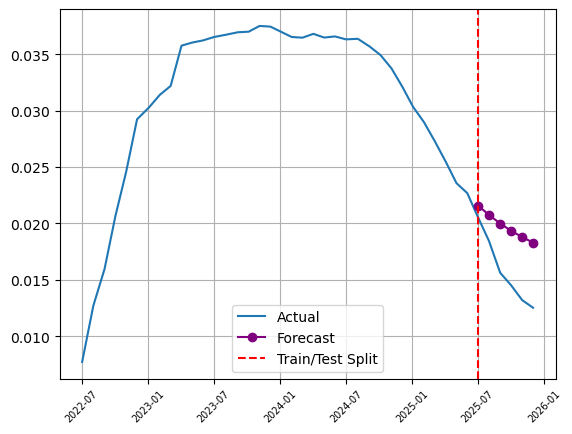

         Date    3MSORA
30 2025-01-03  0.030340
31 2025-02-02  0.028990
32 2025-03-04  0.027299
33 2025-04-03  0.025500
34 2025-05-03  0.023580
35 2025-06-02  0.022690
36 2025-07-02  0.020530
37 2025-08-01  0.018450
38 2025-09-01  0.015630
39 2025-10-01  0.014530
40 2025-11-01  0.013200
41 2025-12-01  0.012530


In [8]:
import matplotlib.pyplot as plt
plt.plot(df['Date'], df1, label="Actual") #(Y-axis, X-axis values, label =" ") 
#plt.plot(df1.index, df1, label="Actual")
#plt.figure(figsize(15,10))
plt.xticks(rotation=45,fontsize=7)
plt.plot(df['Date'].iloc[36:],forecast, label="Forecast", color="purple", marker="o") 
plt.axvline(df['Date'].iloc[36], color="red", linestyle="--", label="Train/Test Split")
plt.grid(True)
plt.legend(loc='lower center', fontsize=10) 
plt.show() 
print(df.tail(12))
#you can see the latest 3 months deviation is too large. The forecast even with applied MAPE is still off. How to improve this? 

In [7]:
# Because the training data stops at 3 month before last, the first 3 values are the same as before
#forecast2 = model.forecast(steps=6)  
#print("Forecasted:", forecast2.values)

In [7]:
#Use start, end and select df1 (single column without date) to predict the next 2 months
#See [213] for a better forecast which is lower than 0.01563
pred_out = model.predict(start=len(df1), end=len(df1)+1) 
print(pred_out)

42    0.017886
43    0.017522
Name: predicted_mean, dtype: float64


In [9]:
#I am unable to plot a graph with 2 more months based on my forecast above
#plt.plot(df1.index, df1, label="Actual",color='gray')
#plt.plot(test.index, forecast2, label="Forecast", color="orange", marker="x")

In [10]:
#I adopted another approach - including differencing aftter checking for stationary and do transformation
auto1=train.autocorr()
print(auto1)
adf1=adfuller(train)
adf1[1] #> 0.05 not stationary

0.9732053187147199


0.5200868346438384

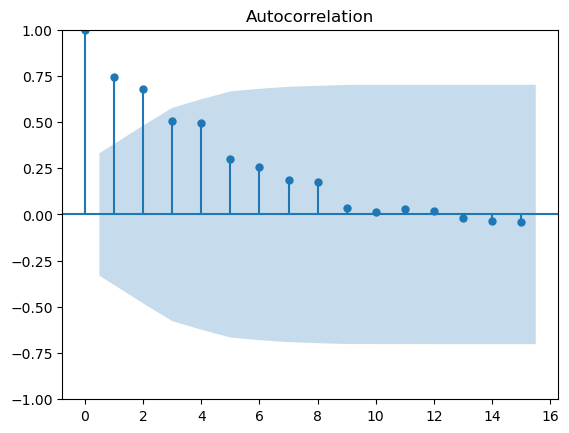

In [17]:
df_diff=train.diff() #this is a df_diff on train 
df_diff=df_diff.dropna()
acf=plot_acf(df_diff,lags=15,alpha=0.05)

In [18]:
import statsmodels.api as sm
res = sm.tsa.arma_order_select_ic(df_diff, max_ar=3, max_ma=3, ic=['aic','bic'])
res

C:\Users\jinsh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'aic':             0           1           2           3
 0 -335.419070 -348.335038 -364.604956 -364.988811
 1 -371.321246 -371.115520 -370.198892 -364.628031
 2 -374.193848 -374.077085 -361.151025 -374.352919
 3 -372.470345 -372.403612 -358.034251 -365.332766,
 'bic':             0           1           2           3
 0 -332.308374 -343.668994 -358.383564 -357.212070
 1 -366.655202 -364.894128 -362.422152 -355.295943
 2 -367.972456 -366.300345 -351.818937 -363.465482
 3 -364.693605 -363.071524 -347.146814 -352.889982,
 'aic_min_order': (2, 3),
 'bic_min_order': (2, 0)}

In [19]:
mod = ARIMA(df_diff, order=(2,1,0))
model1 = mod.fit()
print(model1.summary())
#BIC is higher than the original model 

                               SARIMAX Results                                
Dep. Variable:                 3MSORA   No. Observations:                   35
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 186.564
Date:                Tue, 02 Dec 2025   AIC                           -367.129
Time:                        21:41:05   BIC                           -362.549
Sample:                             0   HQIC                          -365.567
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3919      0.150     -2.617      0.009      -0.685      -0.098
ar.L2          0.0100      0.286      0.035      0.972      -0.551       0.571
sigma2      9.889e-07    1.6e-07      6.179      0.0

C:\Users\jinsh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jinsh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jinsh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [32]:
forecast_diff = model1.forecast(steps=6)  # 6 steps ahead
print("Forecasted:", forecast_diff.values.round(5))
#print("xth month forecast:", round(forecast_diff.iloc[-1],6))

Forecasted: [-0.00129 -0.00113 -0.0012  -0.00117 -0.00118 -0.00117]


C:\Users\jinsh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [33]:
# Invert differencing and checked against test actuals
# 1 NOV 2025: This model forecast is vastly better than above. 
last_actual = train.iloc[-1]  # last observed level before forecast
forecast2 = forecast_diff.cumsum() + last_actual #forecast_diff is a series of numbers, and it will add onto the last actual. 
#print(forecast_levels)
print("Forecast:", forecast2.values)
print("Actual:", test.values)

Forecast: [0.02139517 0.02026926 0.01907311 0.01790618 0.0167271  0.01555306]
Actual: [0.02053 0.01845 0.01563 0.01453 0.0132  0.01253]


In [29]:
rmse = np.sqrt(mean_squared_error(test, forecast2))
mse = mean_squared_error(test, forecast2)
mae = mean_absolute_error(test, forecast2)
mape = mean_absolute_percentage_error(test, forecast2)

print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}") #higher than with actuals

RMSE: 0.0029
MSE: 0.0000
MAE: 0.0027
MAPE: 0.1836


In [30]:
forecast_diff = model1.forecast(steps=3)  # 3 steps ahead
print("Forecasted:", forecast_diff.values)

Forecasted: [-0.00129483 -0.00112591 -0.00119615]


C:\Users\jinsh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\jinsh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [34]:
# Invert differencing and checked against test actuals
#This results are better than the initial model.
last_actual_v1 = df1.iloc[-1]  # last observed level before forecast
forecast_final_v1 = forecast_diff.cumsum() + last_actual_v1 #forecast_diff (above) affect the number of forecasted months.
#RESULTS: print(forecast_levels)
last2=df1.iloc[[-3,-2,-1]].values
print("Preceding 2 months:", last2)
print("Forecast 2 months:", forecast_final_v1.values) #Produce 3 months forecasted based on 

Preceding 2 months: [0.01453 0.0132  0.01253]
Forecast 2 months: [0.01123517 0.01010926 0.00891311]


In [32]:
#Different Model: SARIMAX (ARIMA with Seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_s = SARIMAX(train, order=(2,1,0)) 
model_fit_s = model_s.fit()
print(model_fit_s.summary())

                               SARIMAX Results                                
Dep. Variable:                 3MSORA   No. Observations:                   36
Model:               SARIMAX(2, 1, 0)   Log Likelihood                 189.871
Date:                Tue, 02 Dec 2025   AIC                           -373.742
Time:                        21:36:51   BIC                           -369.076
Sample:                             0   HQIC                          -372.131
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4250      0.132      3.208      0.001       0.165       0.685
ar.L2          0.3821      0.142      2.696      0.007       0.104       0.660
sigma2      1.095e-06   1.96e-07      5.586      0.0

C:\Users\jinsh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
